In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/logs-params/BGL_test_params.csv
/kaggle/input/logs-params/Thunderbird_test_params.csv
/kaggle/input/logs-params/Thunderbird_train_params.csv
/kaggle/input/logs-params/BGL_train_params.csv


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, \
accuracy_score, confusion_matrix ,f1_score, precision_score, recall_score, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
def read_csv(path_to_file,train,test,data,label):
    train_df = pd.read_csv(path_to_file+"/"+train)
    test_df = pd.read_csv(path_to_file+"/"+test)
    print("Train Shape:",train_df.shape,"Test Shape:",test_df.shape)

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
    sns.countplot(x=train_df[label]).set(title=f'Training dataset {data}')
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
    sns.countplot(x=test_df[label]).set(title=f'Testing dataset {data}')
    plt.tight_layout()
    plt.show()


    return train_df,test_df

Train Shape: (79992, 18) Test Shape: (19999, 12)


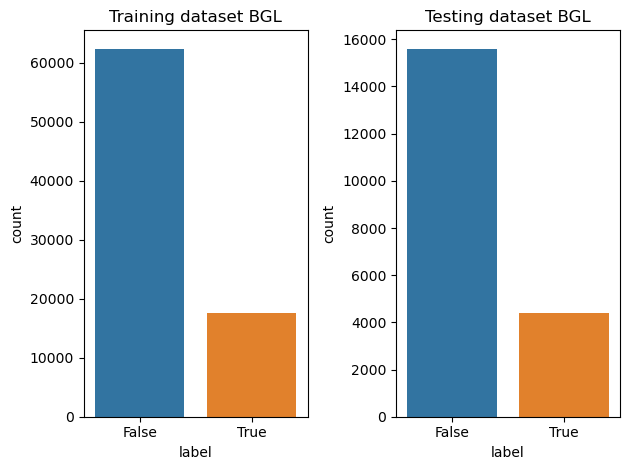

In [5]:
path_to_file="/kaggle/input/logs-params"
train="BGL_train_params.csv"
test="BGL_test_params.csv"
data='BGL'
label='label'

BGL_train,BGL_test=read_csv(path_to_file,train,test,data,label)

Train Shape: (79999, 20) Test Shape: (20001, 11)


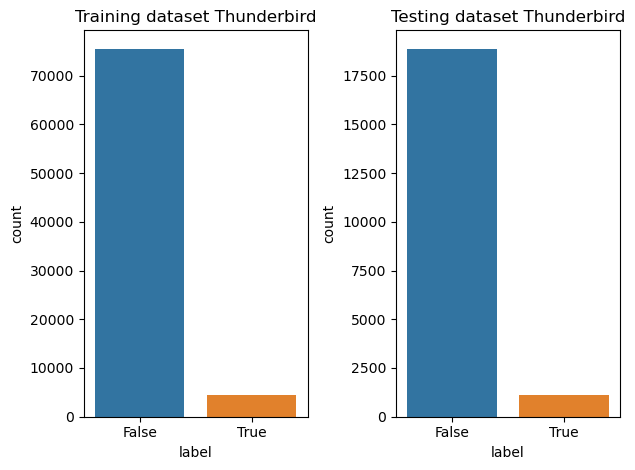

In [6]:
path_to_file="/kaggle/input/logs-params"
train="Thunderbird_train_params.csv"
test="Thunderbird_test_params.csv"
label='label'
data='Thunderbird'

thunder_train,thunder_test=read_csv(path_to_file,train,test,data,label)

### Features(columns):
*Cluster columns*:
All the token columns from TFIDF log statements were grouped into clusters. Log statements that share many words in common tend to have the same log form, and are grouped into a single cluster. <br>
*Params columns*:
The statistical distribution of tokens within each cluster were used to detect unique tokens within each cluster, which were then extracted as parameters.


In [7]:
thunder_train.columns

Index(['Unnamed: 0', 'timestamp', 'text', 'label', 'filename', 'clusters',
       'p-0-0', 'p-0-1', 'p-0-2', 'p-0-3', 'p-0-4', 'p-0-5', 'p-0-6', 'p-4-0',
       'p-8-0', 'p-9-0', 'p-11-0', 'p-18-0', 'p-37-0', 'p-37-1'],
      dtype='object')

In [8]:
thunder_test.columns

Index(['Unnamed: 0', 'timestamp', 'text', 'label', 'filename', 'clusters',
       'p-0-0', 'p-0-1', 'p-0-2', 'p-8-0', 'p-18-0'],
      dtype='object')

In [9]:
thunder_train.head(2)

,Unnamed: 0,timestamp,text,label,filename,clusters,p-0-0,p-0-1,p-0-2,p-0-3,p-0-4,p-0-5,p-0-6,p-4-0,p-8-0,p-9-0,p-11-0,p-18-0,p-37-0,p-37-1
0,0,1131674786000,dhcpd: DHCPREQUEST for 10.100.4.251 (10.100.0....,False,src@aadmin2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1131674786000,dhcpd: DHCPDISCOVER from 00:11:43:e3:ba:c3 via...,False,src@aadmin3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def encoding(train,test,cluster=None,label=None):

    le = LabelEncoder()
    ohe = OneHotEncoder()

    train_dummies = pd.get_dummies(train['clusters'])
    train['label'] = le.fit_transform(train['label'])

    test_dummies = pd.get_dummies(test['clusters'])
    test['label'] = le.fit_transform(test['label'])

    for col in train_dummies.columns:
        if not col in test_dummies.columns:
            continue
        col_name = 'c' + str(col)
        train[col_name] = train_dummies[col]
        test[col_name] = test_dummies[col]

    train.drop(columns=['clusters'], inplace=True)
    test.drop(columns=['clusters'], inplace=True)
    train.head()
    return train,test

In [11]:
encoded_train_BGL,encoded_test_BGL= encoding(BGL_train,BGL_test,cluster='clusters',label='label')
encoded_train_t,encoded_test_t= encoding(thunder_train,thunder_test,cluster='clusters',label='label')

In [12]:
def train_test(train, test):
    for col in train.columns:
        if col not in test.columns:
            test[col] = 0
    
    for col in test.columns:
        if col not in train.columns:
            train[col] = 0

    X_train= train.drop(columns = ['Unnamed: 0', 'label','text','filename','timestamp'])
    X_train.fillna(0,inplace=True)
    y_train=train.loc[:,'label']
    
    X_test= test.drop(columns = ['Unnamed: 0', 'label','text','filename','timestamp'])
    X_test.fillna(0,inplace=True)
    y_test=test.loc[:,'label']
    
    return X_train,y_train.values,X_test,y_test.values

In [13]:
x_train_BGL,y_train_BGL,x_test_BGL,y_test_BGL = train_test(encoded_train_BGL,encoded_test_BGL)
x_train_t,y_train_t,x_test_t,y_test_t=train_test(encoded_train_t,encoded_test_t)

In [14]:
print("columns for the x_test file"+ str(x_test_t.columns))
print("columns for the x_train file"+ str(x_train_t.columns))

columns for the x_test fileIndex(['p-0-0', 'p-0-1', 'p-0-2', 'p-8-0', 'p-18-0', 'c0', 'c1', 'c2', 'c3',
       'c5', 'c6', 'c8', 'c9', 'c10', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18',
       'c20', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c29', 'c32', 'c33',
       'c34', 'c35', 'c36', 'c38', 'c39', 'p-0-3', 'p-0-4', 'p-0-5', 'p-0-6',
       'p-4-0', 'p-9-0', 'p-11-0', 'p-37-0', 'p-37-1'],
      dtype='object')
columns for the x_train fileIndex(['p-0-0', 'p-0-1', 'p-0-2', 'p-0-3', 'p-0-4', 'p-0-5', 'p-0-6', 'p-4-0',
       'p-8-0', 'p-9-0', 'p-11-0', 'p-18-0', 'p-37-0', 'p-37-1', 'c0', 'c1',
       'c2', 'c3', 'c5', 'c6', 'c8', 'c9', 'c10', 'c13', 'c14', 'c15', 'c16',
       'c17', 'c18', 'c20', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c29',
       'c32', 'c33', 'c34', 'c35', 'c36', 'c38', 'c39'],
      dtype='object')


In [15]:
x_train_BGL = x_train_BGL[x_test_BGL.columns]
x_train_t=x_train_t[x_test_t.columns]

In [16]:
# verify that training and testing sets share the same features
x_train_t.columns==x_test_t.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [17]:
print(x_train_BGL.shape,y_train_BGL.shape,x_test_BGL.shape,y_test_BGL.shape)
print(x_train_t.shape,y_train_t.shape,x_test_t.shape,y_test_t.shape)

(79992, 28) (79992,) (19999, 28) (19999,)
(79999, 44) (79999,) (20001, 44) (20001,)


## Logistic Regression

## BGL

### Feature Importance
By analyzing feature importance, we can gain insights into which features have the most impact on the model's predictions. This helps us understand which variables are driving the model's decision-making process.

In [18]:
lr_BGL = LogisticRegression(class_weight='balanced')
lr_BGL.fit(x_train_BGL, y_train_BGL)

LogisticRegression(class_weight='balanced')

In [19]:
# Get the coefficients and their corresponding feature names
coefficients = lr_BGL.coef_[0]
feature_names = x_train_BGL.columns

# Sort the coefficients and feature names in descending order of magnitude
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Print the sorted feature importance
for feature, coef in zip(sorted_feature_names, abs(sorted_coefficients)):
    print(f"{feature}: {coef}")

c0: 10.587082041013051
c1: 9.889769175756415
c36: 8.90320103412684
c9: 6.5768833032804865
c8: 6.458652947594999
c28: 6.219683224117132
c39: 5.910743209155948
c22: 5.89209923040099
c12: 5.863369212884018
c13: 5.6977050859899085
c6: 5.662875570199335
c24: 5.447157445947319
c5: 4.799377346482286
c37: 4.495495163793142
c25: 4.073814948896466
p-4-0: 3.3256854908404803
p-31-0: 2.3683776664070515
c31: 2.3053774640776035
p-25-0: 1.264019650553995
p-7-1: 1.1756968995743042
p-7-0: 0.7837979330495362
p-6-0: 0.7644188829893487
p-25-1: 0.3070259501011531
p-14-0: 0.0996836473930617
p-36-0: 0.09518468061592374
p-36-1: 0.06504567877473404
p-36-3: 0.004490318792693897
p-36-2: 0.002993545861795925


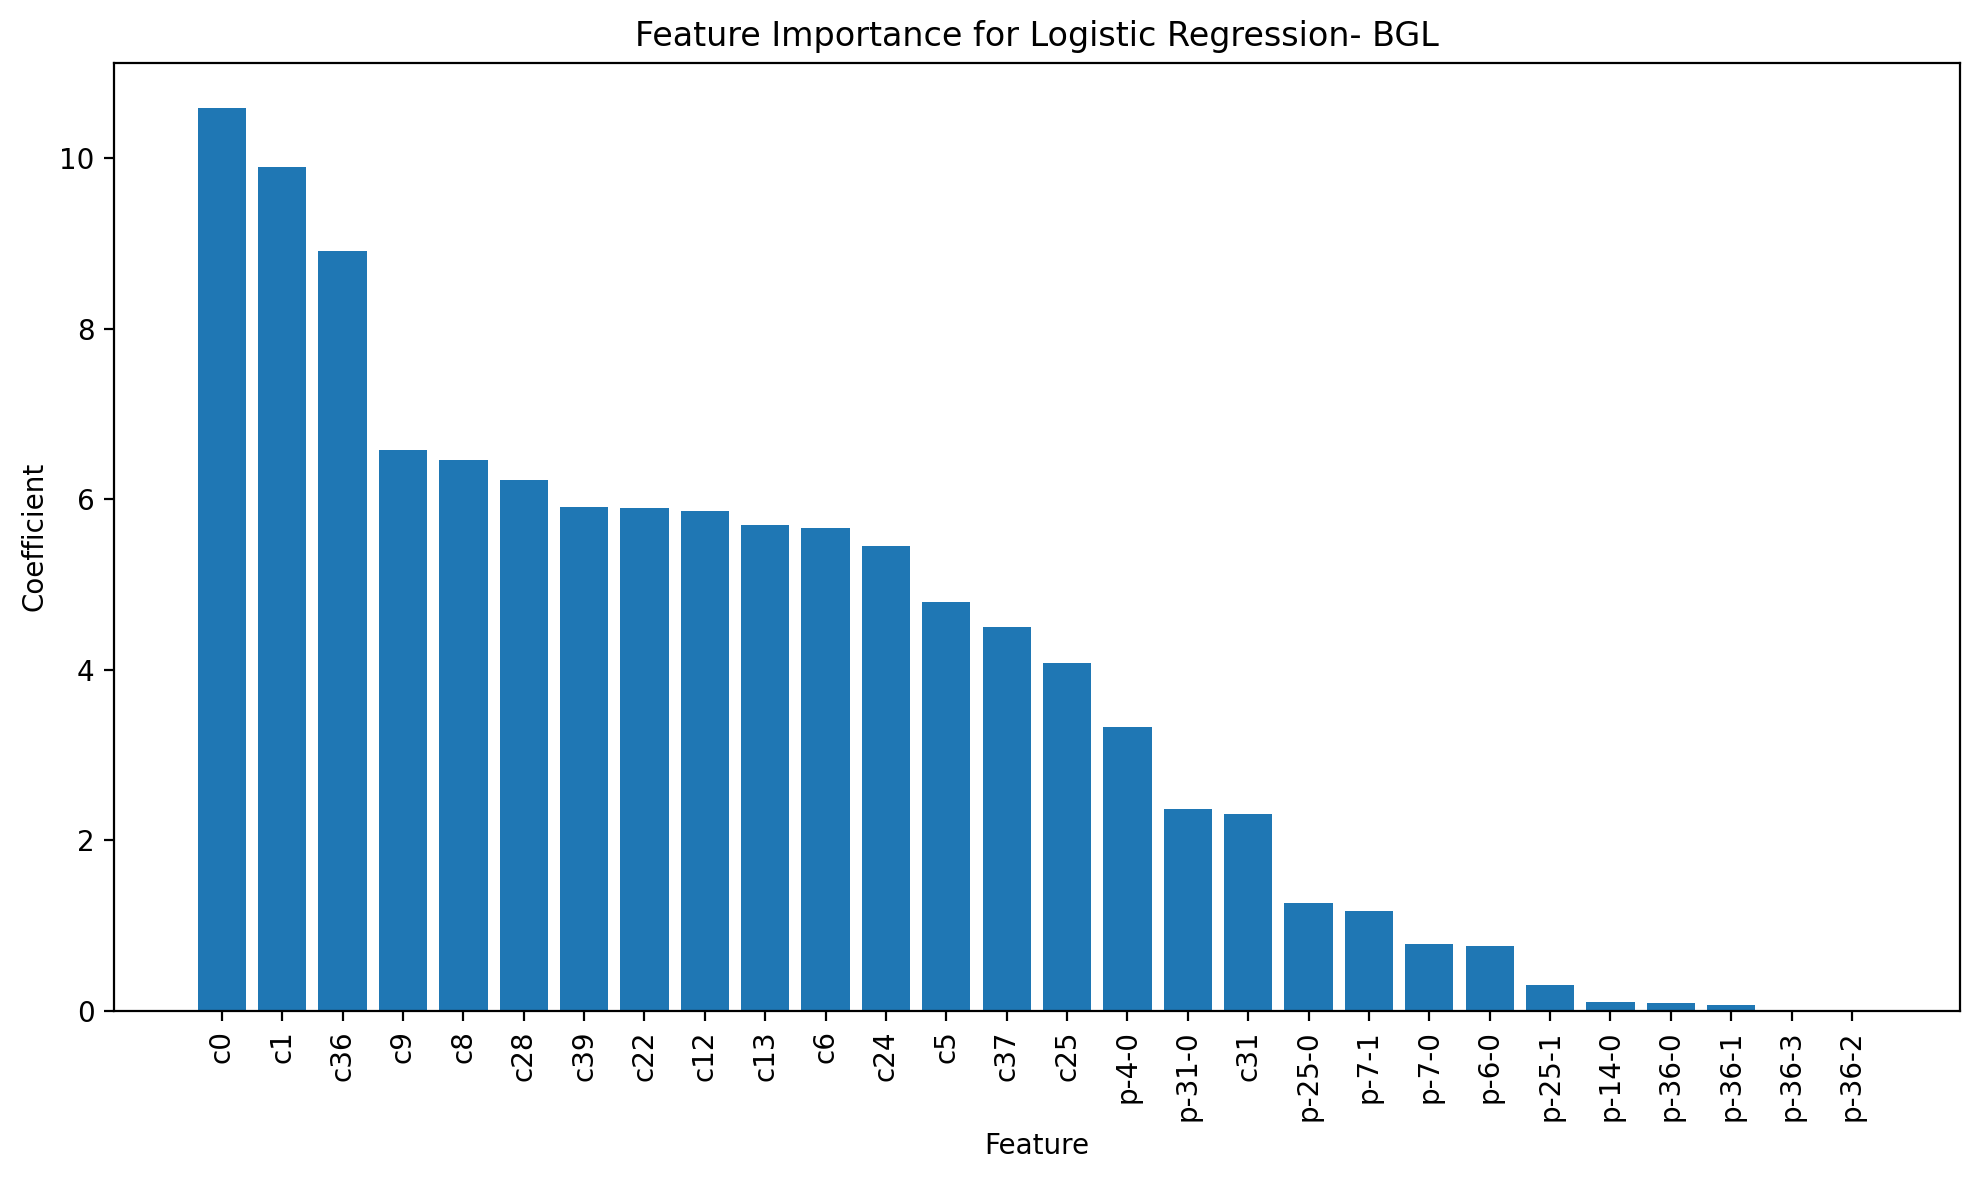

In [20]:
# Plot the feature importance using bar plot
plt.figure(figsize=(10, 6),dpi=200)
plt.bar(range(len(sorted_feature_names)), abs(sorted_coefficients), align='center')
plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Importance for Logistic Regression- BGL')
plt.tight_layout()
plt.show()

### Predictions on train data (BGL)

Train Result:
Accuracy Score: 97.41%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      1.000000      0.894761  0.974135      0.947380      0.976857
recall         0.966843      1.000000  0.974135      0.983422      0.974135
f1-score       0.983142      0.944458  0.974135      0.963800      0.974635
support    62401.000000  17591.000000  0.974135  79992.000000  79992.000000
_______________________________________________
Confusion Matrix: 
 [[60332  2069]
 [    0 17591]]

_______________________________________________
Recall Score: 
 1.0
_______________________________________________
Roc AUC Score: 
 0.9834217400362173


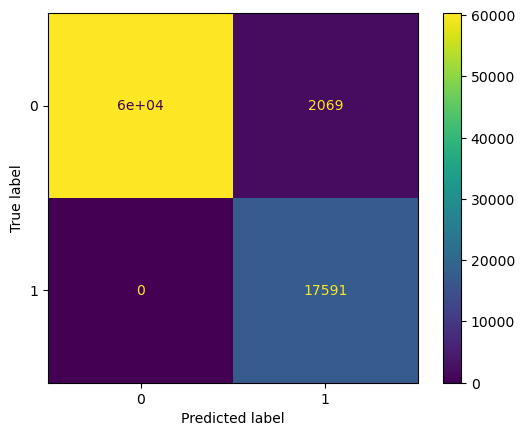

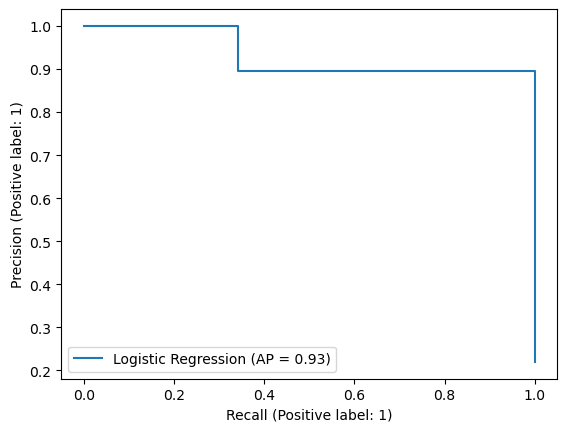

In [21]:
pred_BGL = lr_BGL.predict(x_train_BGL)
lr_report = pd.DataFrame(classification_report(y_train_BGL, pred_BGL, output_dict=True))
print("Train Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_train_BGL, pred_BGL) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{lr_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_train_BGL, pred_BGL)}\n")
print("_______________________________________________")
print(f'Recall Score: \n {recall_score(y_train_BGL, pred_BGL)}')
print("_______________________________________________")
print(f'Roc AUC Score: \n {roc_auc_score(y_train_BGL, pred_BGL)}')

lr_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_train_BGL, pred_BGL)
plt.show()


from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    lr_BGL, x_train_BGL, y_train_BGL, name="Logistic Regression"
)

### Predictions on testing data(BGL)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                 0       1  accuracy  macro avg  weighted avg
precision      1.0     1.0       1.0        1.0           1.0
recall         1.0     1.0       1.0        1.0           1.0
f1-score       1.0     1.0       1.0        1.0           1.0
support    15601.0  4398.0       1.0    19999.0       19999.0
_______________________________________________
Confusion Matrix: 
 [[15601     0]
 [    0  4398]]

_______________________________________________
Recall Score: 
 1.0
_______________________________________________
Roc AUC Score: 
 1.0


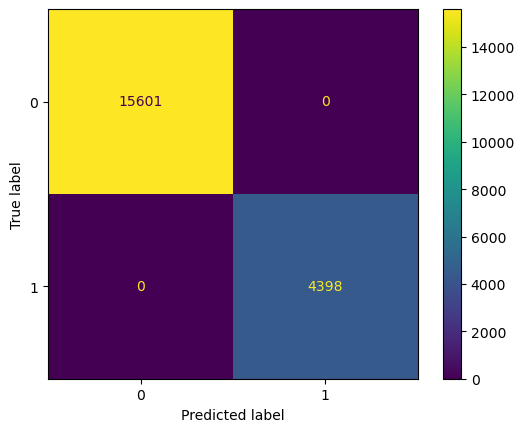

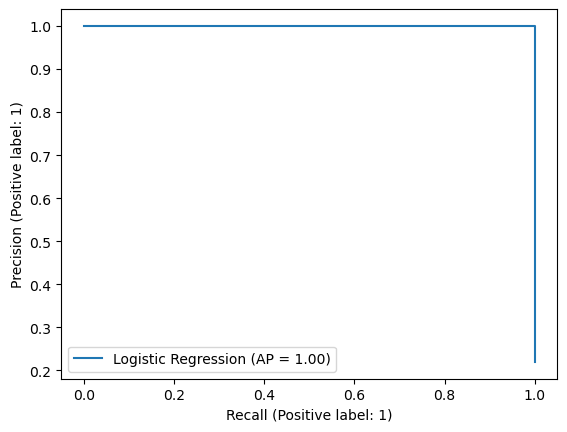

In [22]:
pred = lr_BGL.predict(x_test_BGL)
lr_report = pd.DataFrame(classification_report(y_test_BGL, pred, output_dict=True))
print("Train Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test_BGL, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{lr_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test_BGL, pred)}\n")
print("_______________________________________________")
print(f'Recall Score: \n {recall_score(y_test_BGL, pred)}')
print("_______________________________________________")
print(f'Roc AUC Score: \n {roc_auc_score(y_test_BGL, pred)}')

lr_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test_BGL, pred)
plt.show()

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    lr_BGL, x_test_BGL, y_test_BGL, name="Logistic Regression"
)

### Thunderbird

### Feature Importance

In [23]:
lr_t = LogisticRegression(class_weight='balanced')
lr_t.fit(x_train_t, y_train_t)

LogisticRegression(class_weight='balanced')

In [24]:
# Get the coefficients and their corresponding feature names
coefficients = lr_t.coef_[0]
feature_names = x_train_t.columns

# Sort the coefficients and feature names in descending order of magnitude
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Print the sorted feature importance
for feature, coef in zip(sorted_feature_names, abs(sorted_coefficients)):
    print(f"{feature}: {coef}")

c5: 14.893383329866106
c0: 2.4126335432592017
c6: 1.0243980925420446
c39: 0.9650378527295665
p-0-1: 0.8938040925606607
c3: 0.869485763119857
c1: 0.8694304947062106
c8: 0.664391952191335
c23: 0.38567597348996824
c10: 0.3699158294825654
c20: 0.36939566335215335
c24: 0.3688747425151175
c13: 0.3683530652193603
c15: 0.3654702396172634
c17: 0.35990190055456117
c22: 0.35124922533450736
c9: 0.3238718931307936
c27: 0.22167352629433856
c32: 0.22091287131699755
c34: 0.220532034034872
c29: 0.22015085627935171
c38: 0.22015085627935171
c36: 0.22015085627935171
c16: 0.22015085627935171
c2: 0.22015085627935171
c25: 0.21976933759105685
c14: 0.21862273132459245
c33: 0.21823984429632465
c35: 0.21747304005210694
c26: 0.21708912190729124
p-9-0: 0.12201431451499774
p-18-0: 0.09334058485404464
p-11-0: 0.09273735257120368
p-37-0: 0.07155217739892379
p-4-0: 0.06168242199519673
p-0-2: 0.050080795229089786
p-37-1: 0.03449819132318589
p-0-5: 0.02585366054556612
p-0-4: 0.018600999208695557
p-0-6: 0.017424578280087

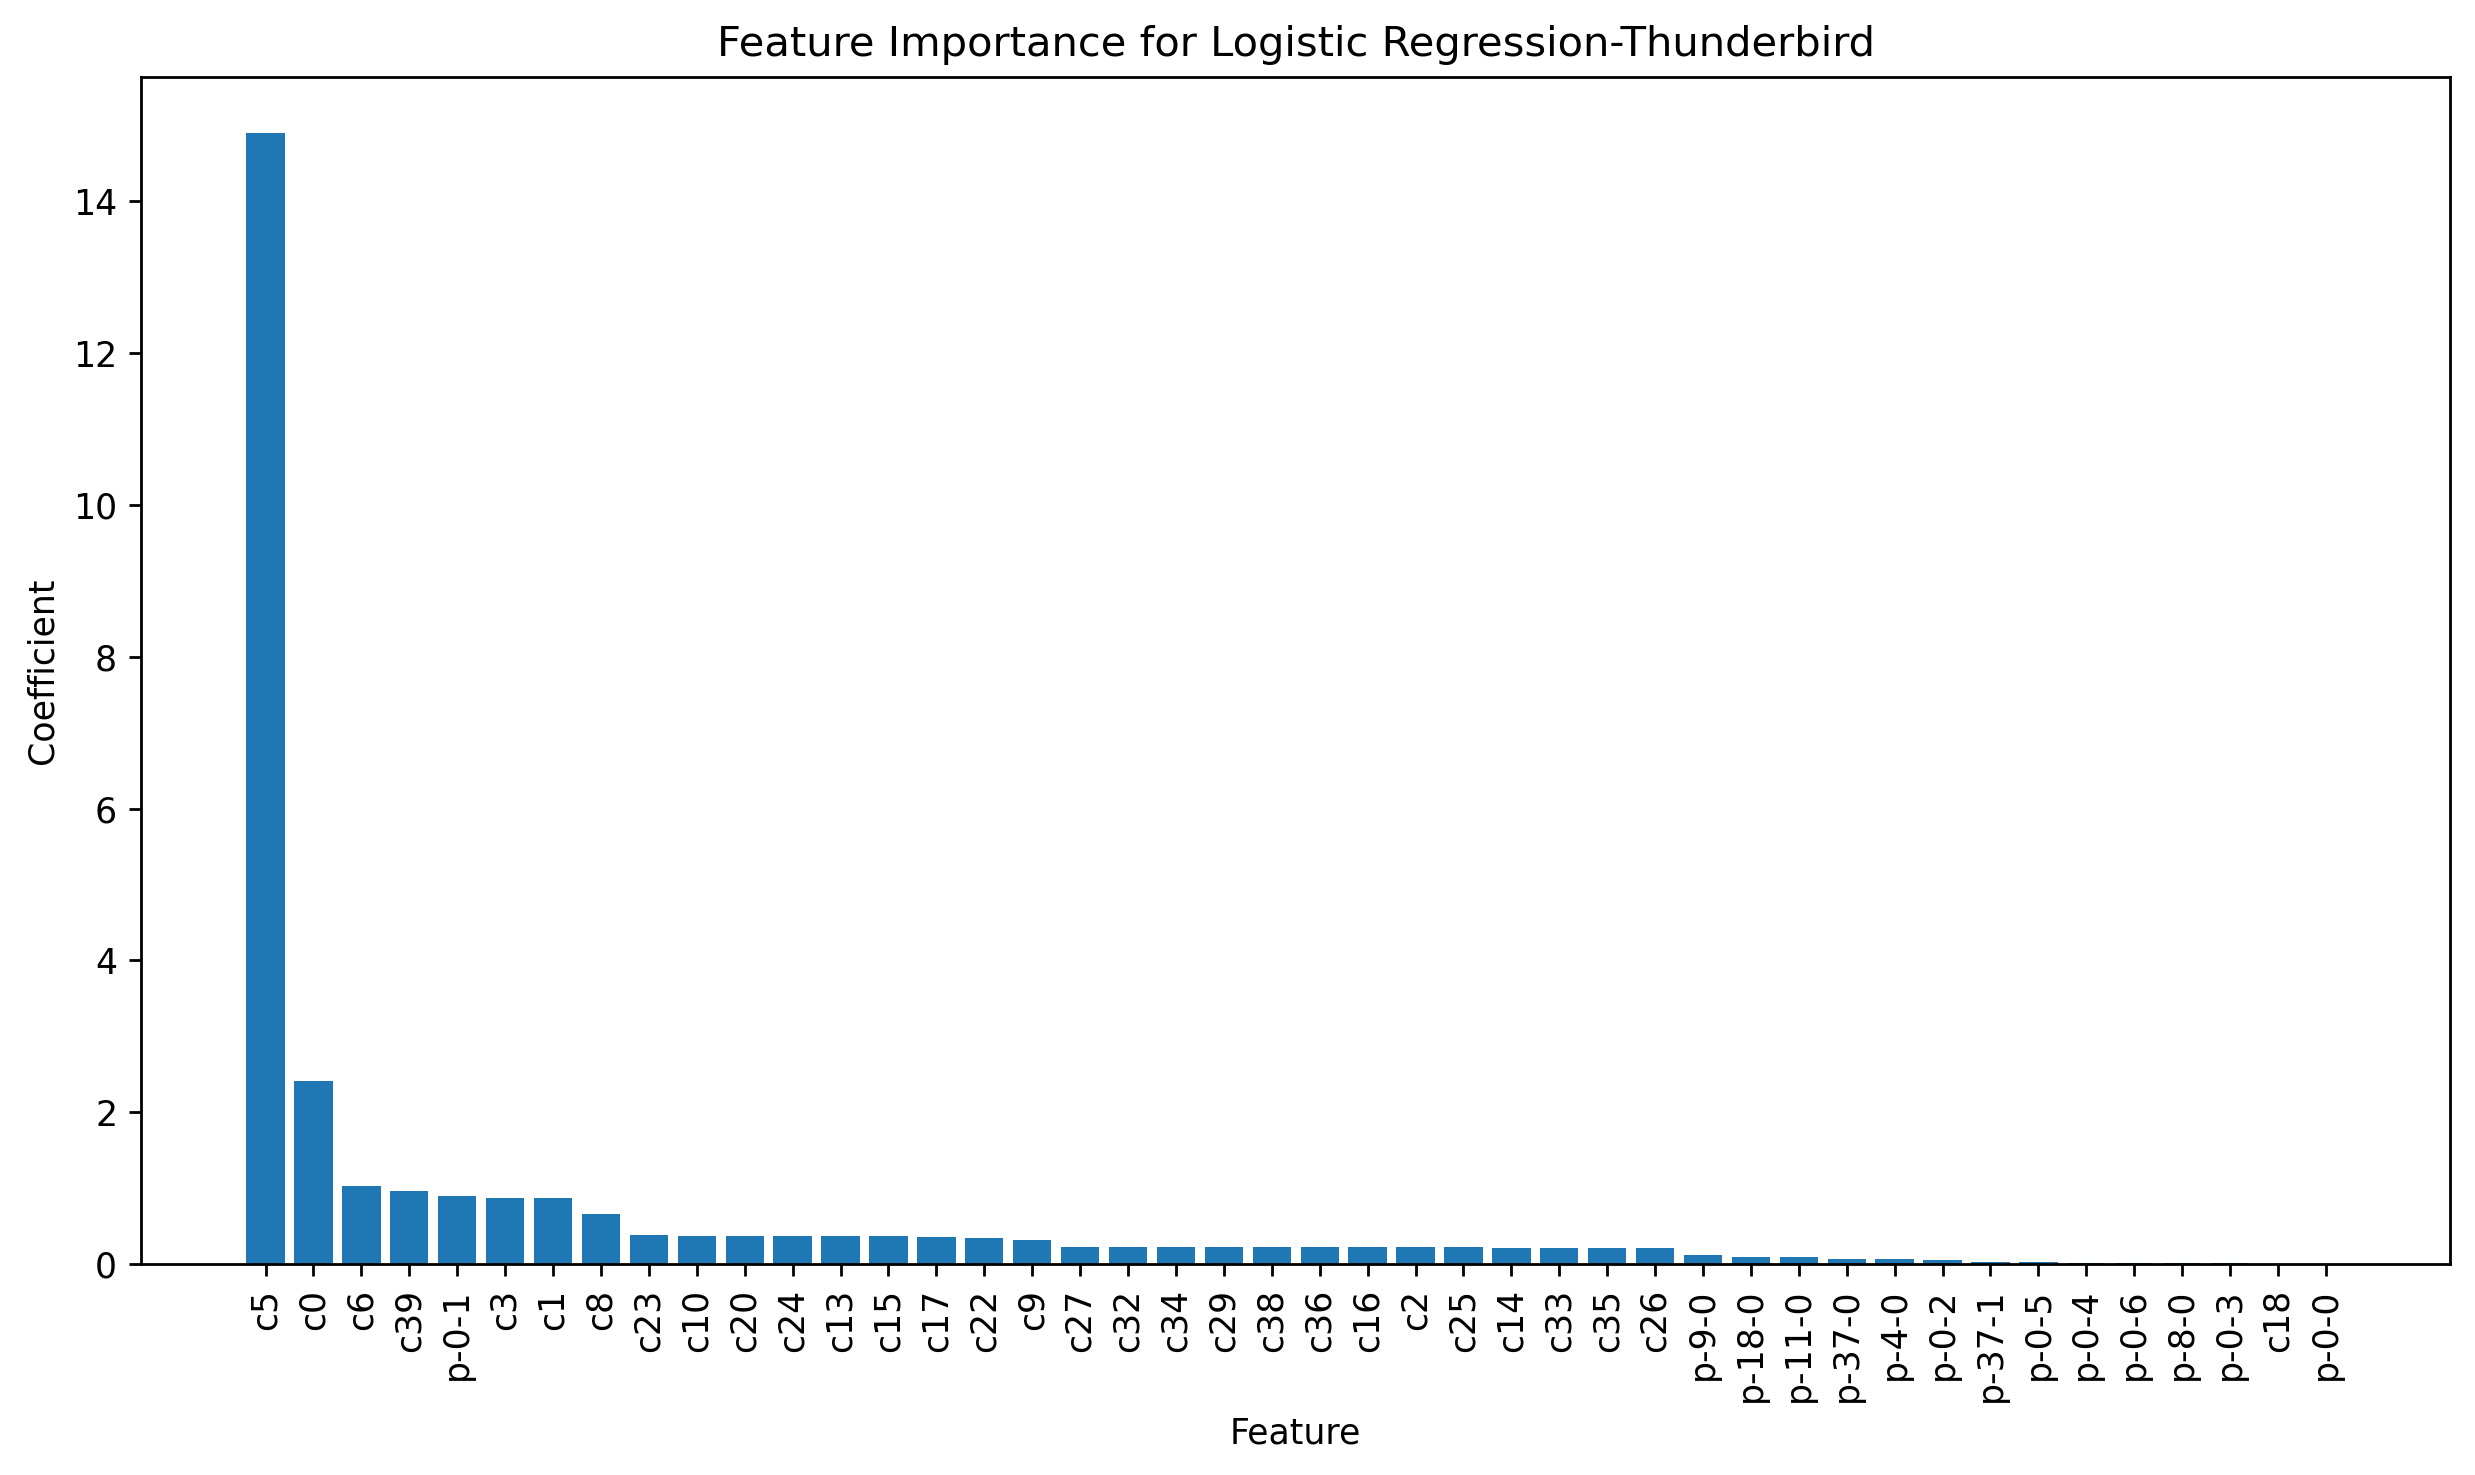

In [25]:
# Plot the feature importance using bar plot
plt.figure(figsize=(10, 6),dpi=250)
plt.bar(range(len(sorted_feature_names)), abs(sorted_coefficients), align='center')
plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Importance for Logistic Regression-Thunderbird')
plt.tight_layout()
plt.show()

### Predictions on training data

Test Result:
Accuracy Score: 99.99%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999960     0.999553  0.999937      0.999757      0.999937
recall         0.999974     0.999330  0.999937      0.999652      0.999937
f1-score       0.999967     0.999442  0.999937      0.999704      0.999937
support    75521.000000  4478.000000  0.999937  79999.000000  79999.000000
_______________________________________________
Confusion Matrix: 
 [[75519     2]
 [    3  4475]]

_______________________________________________
Recall Score: 
 0.9993300580616347
_______________________________________________
Roc AUC Score: 
 0.9996517876807293


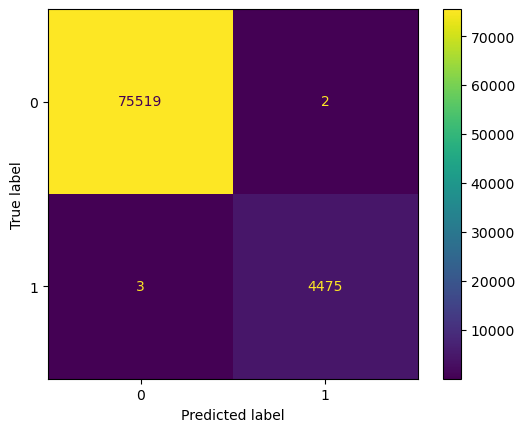

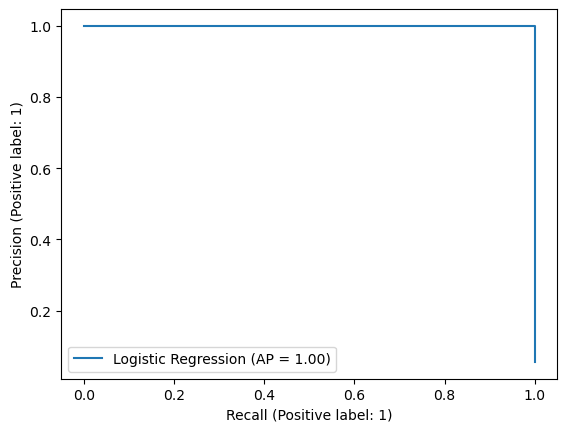

In [26]:
pred = lr_t.predict(x_train_t)
lr_report = pd.DataFrame(classification_report(y_train_t, pred, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_train_t, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{lr_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_train_t, pred)}\n")
print("_______________________________________________")
print(f'Recall Score: \n {recall_score(y_train_t, pred)}')
print("_______________________________________________")
print(f'Roc AUC Score: \n {roc_auc_score(y_train_t, pred)}')

lr_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_train_t, pred)
plt.show()


from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    lr_t, x_train_t, y_train_t, name="Logistic Regression"
)

### Predictions on testing data

Test Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999947     1.000000   0.99995      0.999974       0.99995
recall         1.000000     0.999107   0.99995      0.999554       0.99995
f1-score       0.999974     0.999553   0.99995      0.999763       0.99995
support    18881.000000  1120.000000   0.99995  20001.000000   20001.00000
_______________________________________________
Confusion Matrix: 
 [[18881     0]
 [    1  1119]]

_______________________________________________
Recall Score: 
 0.9991071428571429
_______________________________________________
Roc AUC Score: 
 0.9995535714285715


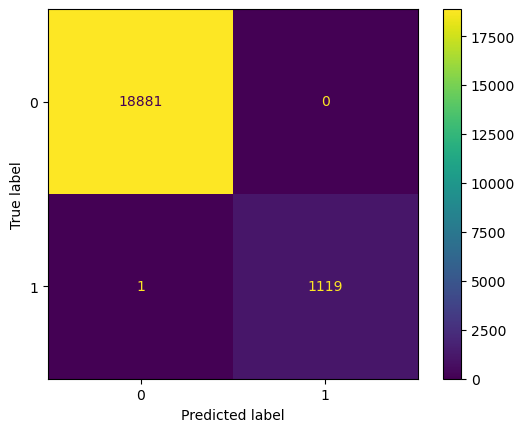

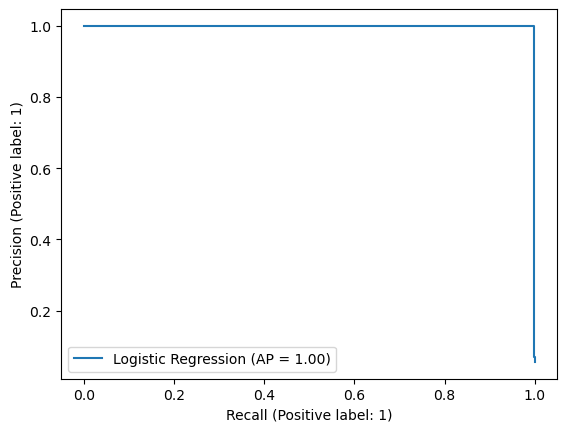

In [71]:
pred = lr_t.predict(x_test_t)
lr_report = pd.DataFrame(classification_report(y_test_t, pred, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test_t, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{lr_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test_t, pred)}\n")
print("_______________________________________________")
print(f'Recall Score: \n {recall_score(y_test_t, pred)}')
print("_______________________________________________")
print(f'Roc AUC Score: \n {roc_auc_score(y_test_t, pred)}')

lr_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test_t, pred)
plt.show()

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    lr_t, x_test_t, y_test_t, name="Logistic Regression"
)

# XGBoost

### Thunderbird

In [43]:
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

bst = XGBClassifier(booster= "gbtree", verbosity=0,
                    n_estimators=2, max_depth=2, learning_rate=0.3, objective='binary:logistic')
# fit model
bst.fit(x_train_t, y_train_t)
# make predictions
preds_test = bst.predict(x_test_t)
preds_train= bst.predict(x_train_t)


[('c5', 1.0), ('p-37-1', 0.0), ('c8', 0.0), ('c18', 0.0), ('c17', 0.0), ('c16', 0.0), ('c15', 0.0), ('c14', 0.0), ('c13', 0.0), ('c10', 0.0), ('c9', 0.0), ('c6', 0.0), ('p-37-0', 0.0), ('c3', 0.0), ('c2', 0.0), ('c1', 0.0), ('c0', 0.0), ('p-18-0', 0.0), ('p-8-0', 0.0), ('p-0-2', 0.0), ('p-0-1', 0.0), ('c20', 0.0), ('c22', 0.0), ('c23', 0.0), ('c38', 0.0), ('p-11-0', 0.0), ('p-9-0', 0.0), ('p-4-0', 0.0), ('p-0-6', 0.0), ('p-0-5', 0.0), ('p-0-4', 0.0), ('p-0-3', 0.0), ('c39', 0.0), ('c36', 0.0), ('c24', 0.0), ('c35', 0.0), ('c34', 0.0), ('c33', 0.0), ('c32', 0.0), ('c29', 0.0), ('c27', 0.0), ('c26', 0.0), ('c25', 0.0), ('p-0-0', 0.0)]


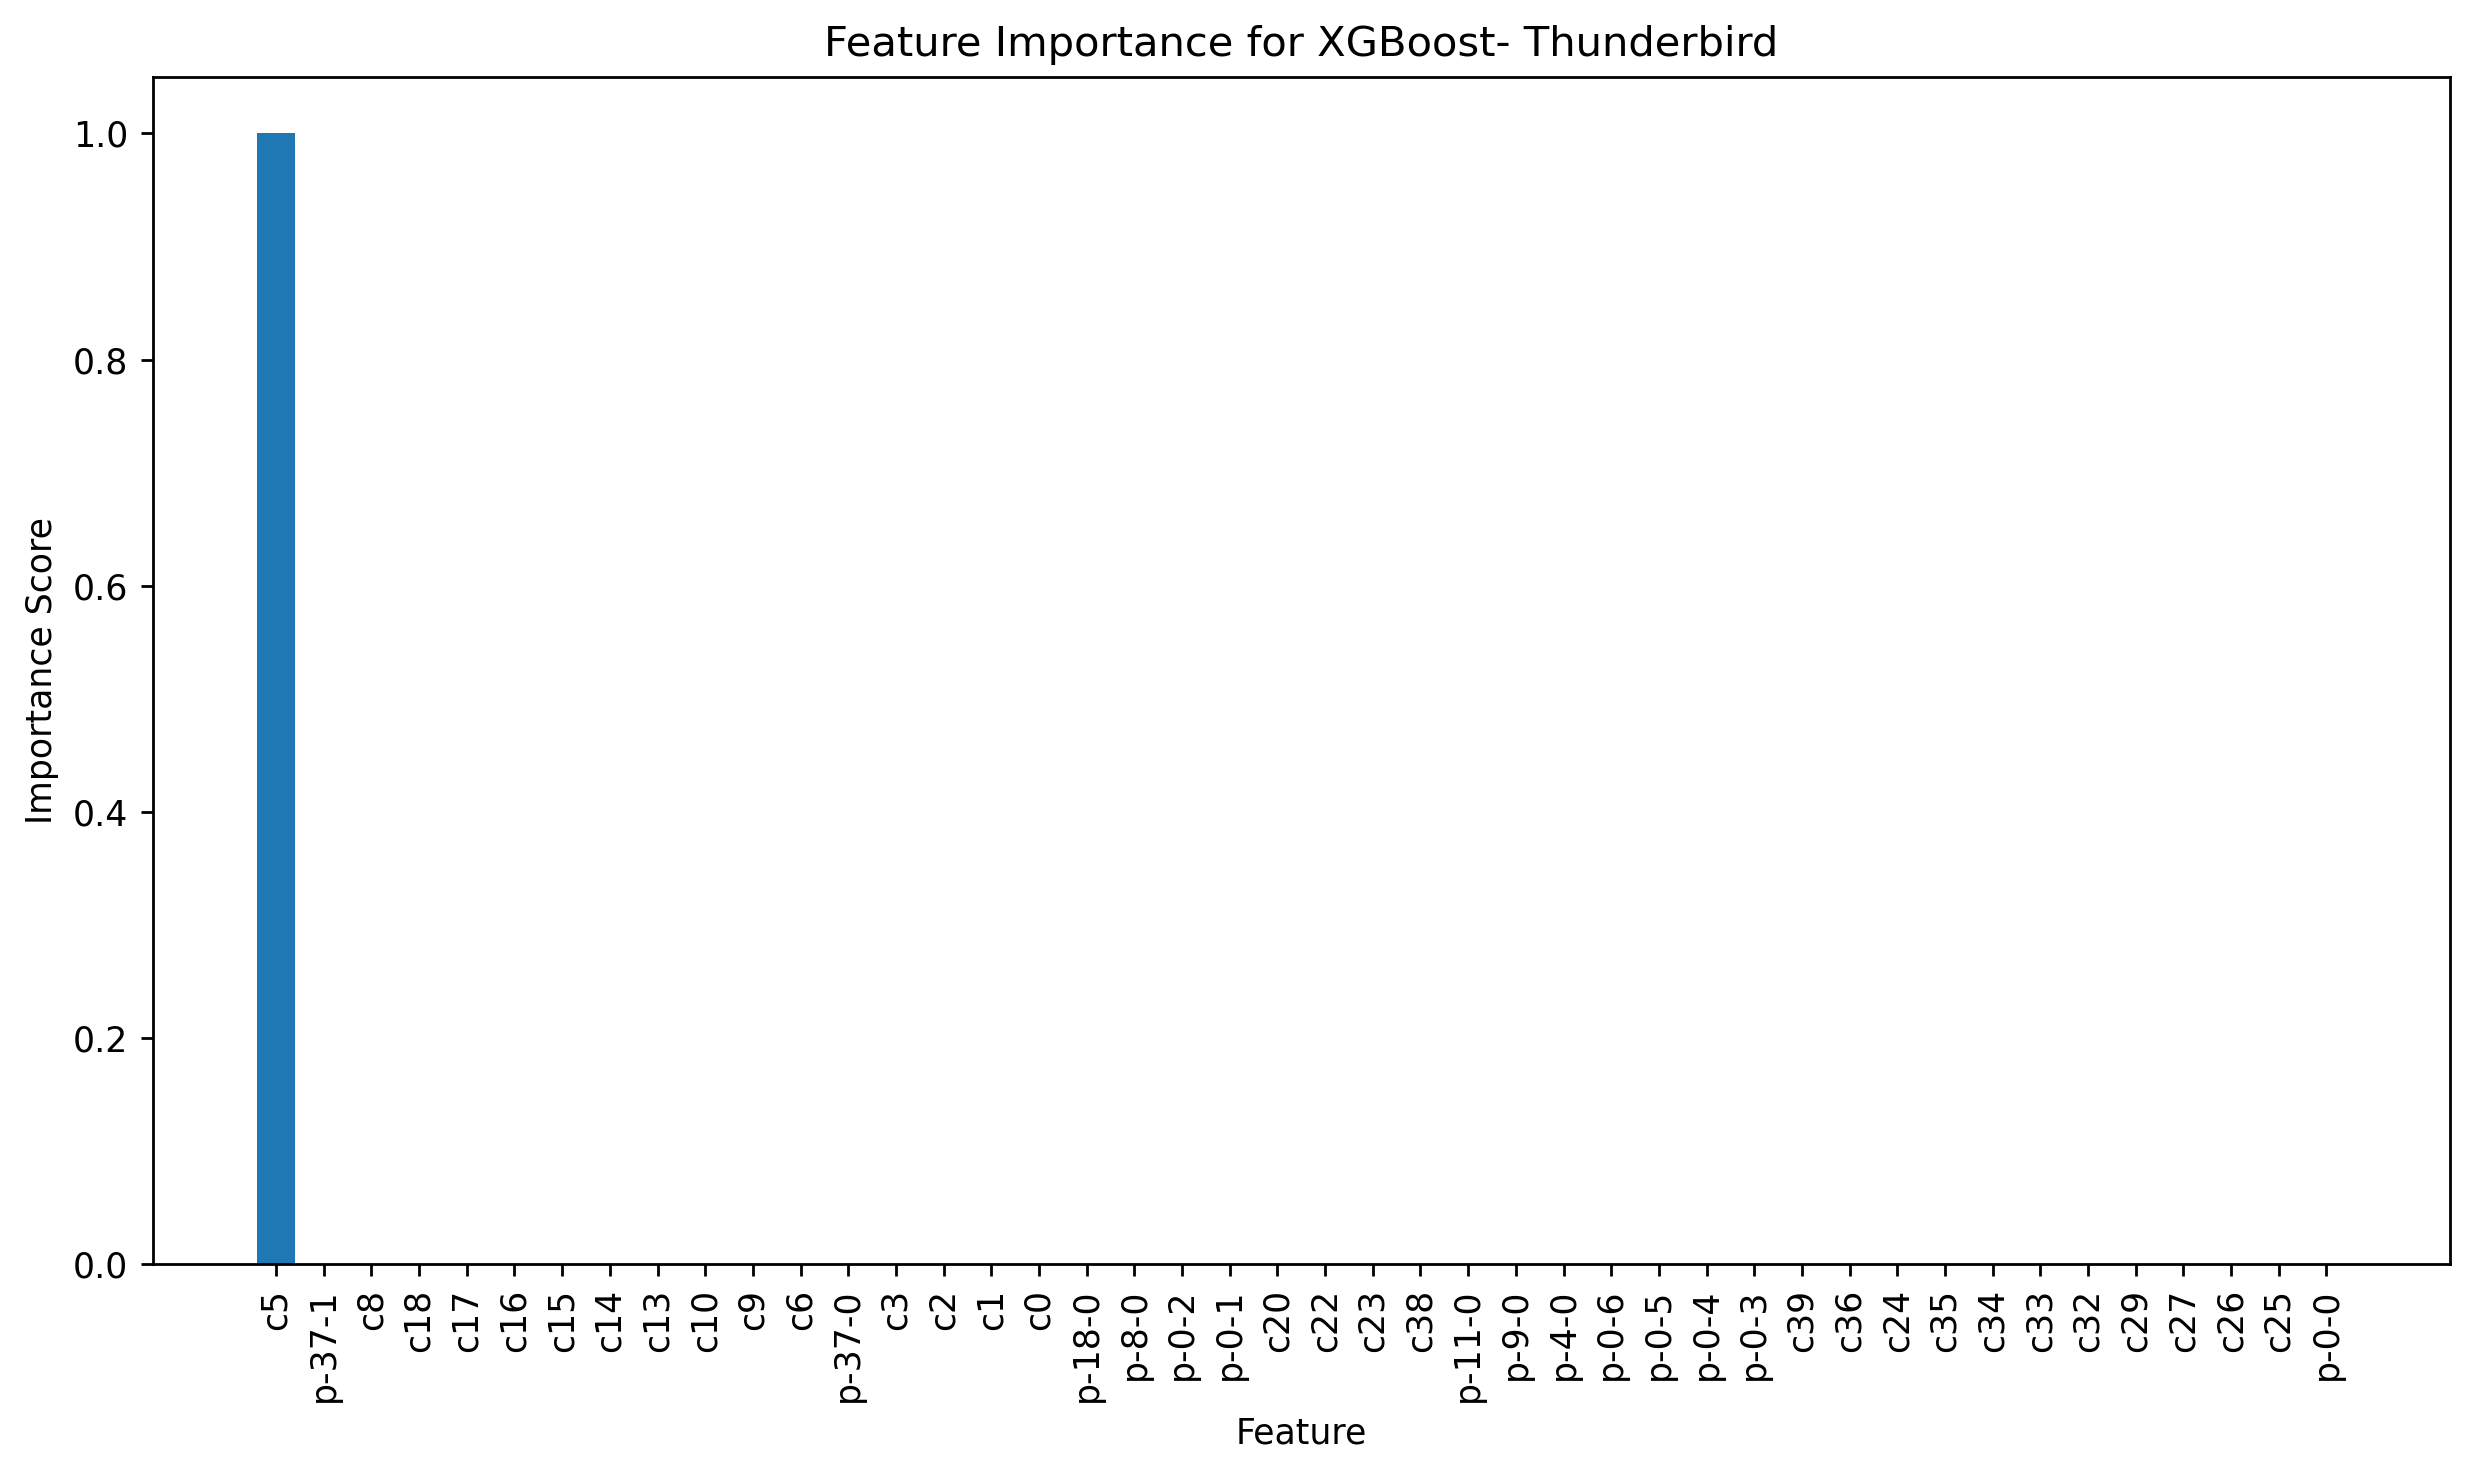

In [44]:
# Get the feature importance scores
importance_scores = bst.feature_importances_
feature_names = x_train_t.columns

# Sort the features based on their importance scores
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_scores = importance_scores[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]
print(list(zip(sorted_feature_names,sorted_scores)))
# Plot the feature importance using bar plot
plt.figure(figsize=(10, 6),dpi=250)
plt.bar(range(len(sorted_feature_names)), sorted_scores, align='center')
plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Feature Importance for XGBoost- Thunderbird')
plt.tight_layout()
plt.show()


### Predictions on training data

Test Result:
Accuracy Score: 99.99%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999960     0.999553  0.999937      0.999757      0.999937
recall         0.999974     0.999330  0.999937      0.999652      0.999937
f1-score       0.999967     0.999442  0.999937      0.999704      0.999937
support    75521.000000  4478.000000  0.999937  79999.000000  79999.000000
_______________________________________________
Confusion Matrix: 
 [[75519     2]
 [    3  4475]]

_______________________________________________
Recall Score: 
 0.9993300580616347
_______________________________________________
Roc AUC Score: 
 0.9996517876807293


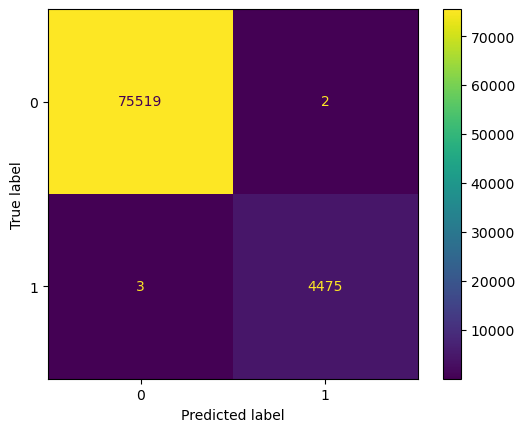

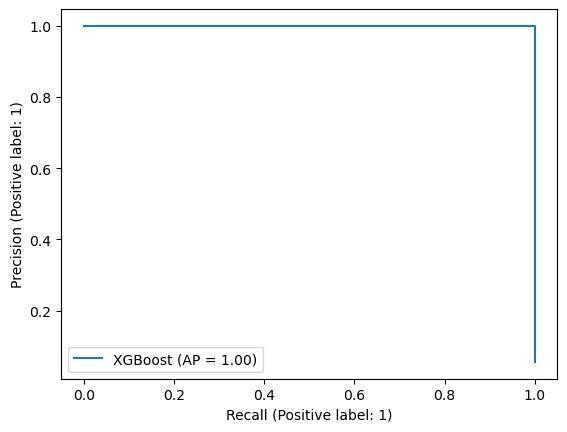

In [45]:
XGBOOST_report = pd.DataFrame(classification_report(y_train_t, preds_train, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_train_t, preds_train) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{lr_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_train_t, preds_train)}\n")
print("_______________________________________________")
print(f'Recall Score: \n {recall_score(y_train_t, preds_train)}')
print("_______________________________________________")
print(f'Roc AUC Score: \n {roc_auc_score(y_train_t, preds_train)}')

XGBOOST_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_train_t, preds_train)
plt.show()


from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    bst, x_train_t, y_train_t, name="XGBoost"
)

### Predictions on test data

Test Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999960     0.999553  0.999937      0.999757      0.999937
recall         0.999974     0.999330  0.999937      0.999652      0.999937
f1-score       0.999967     0.999442  0.999937      0.999704      0.999937
support    75521.000000  4478.000000  0.999937  79999.000000  79999.000000
_______________________________________________
Confusion Matrix: 
 [[18881     0]
 [    1  1119]]

_______________________________________________
Recall Score: 
 0.9991071428571429
_______________________________________________
Roc AUC Score: 
 0.9995535714285715


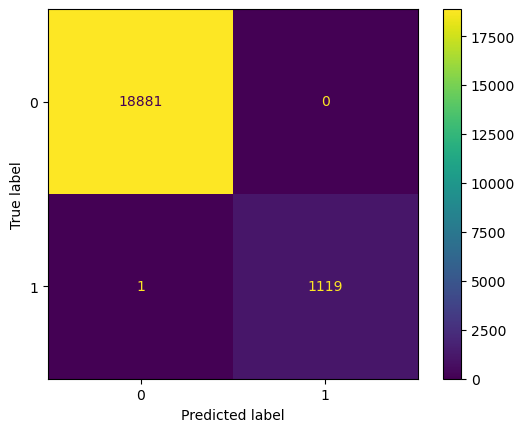

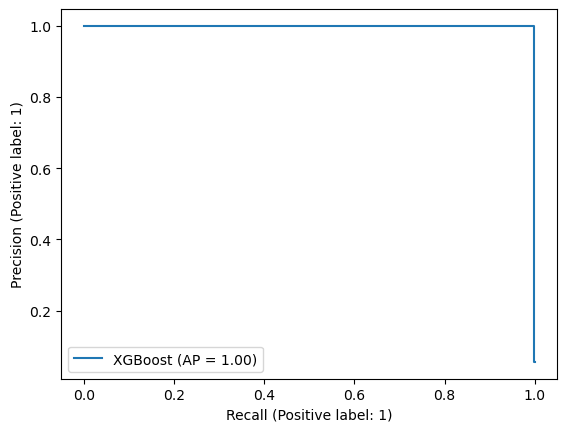

In [46]:
XGBOOST_report = pd.DataFrame(classification_report(y_test_t, preds, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test_t, preds) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{lr_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test_t, preds)}\n")
print("_______________________________________________")
print(f'Recall Score: \n {recall_score(y_test_t, preds)}')
print("_______________________________________________")
print(f'Roc AUC Score: \n {roc_auc_score(y_test_t, preds)}')

XGBOOST_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test_t, preds)
plt.show()


from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    bst, x_test_t, y_test_t, name="XGBoost"
)

### BGL

### Feature Importance

In [50]:
bst_BGL = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, 
                        objective='binary:logistic')
# fit model
bst.fit(x_train_BGL, y_train_BGL)
# make predictions
preds_test = bst.predict(x_test_BGL)
preds_train=bst.predict(x_train_BGL)

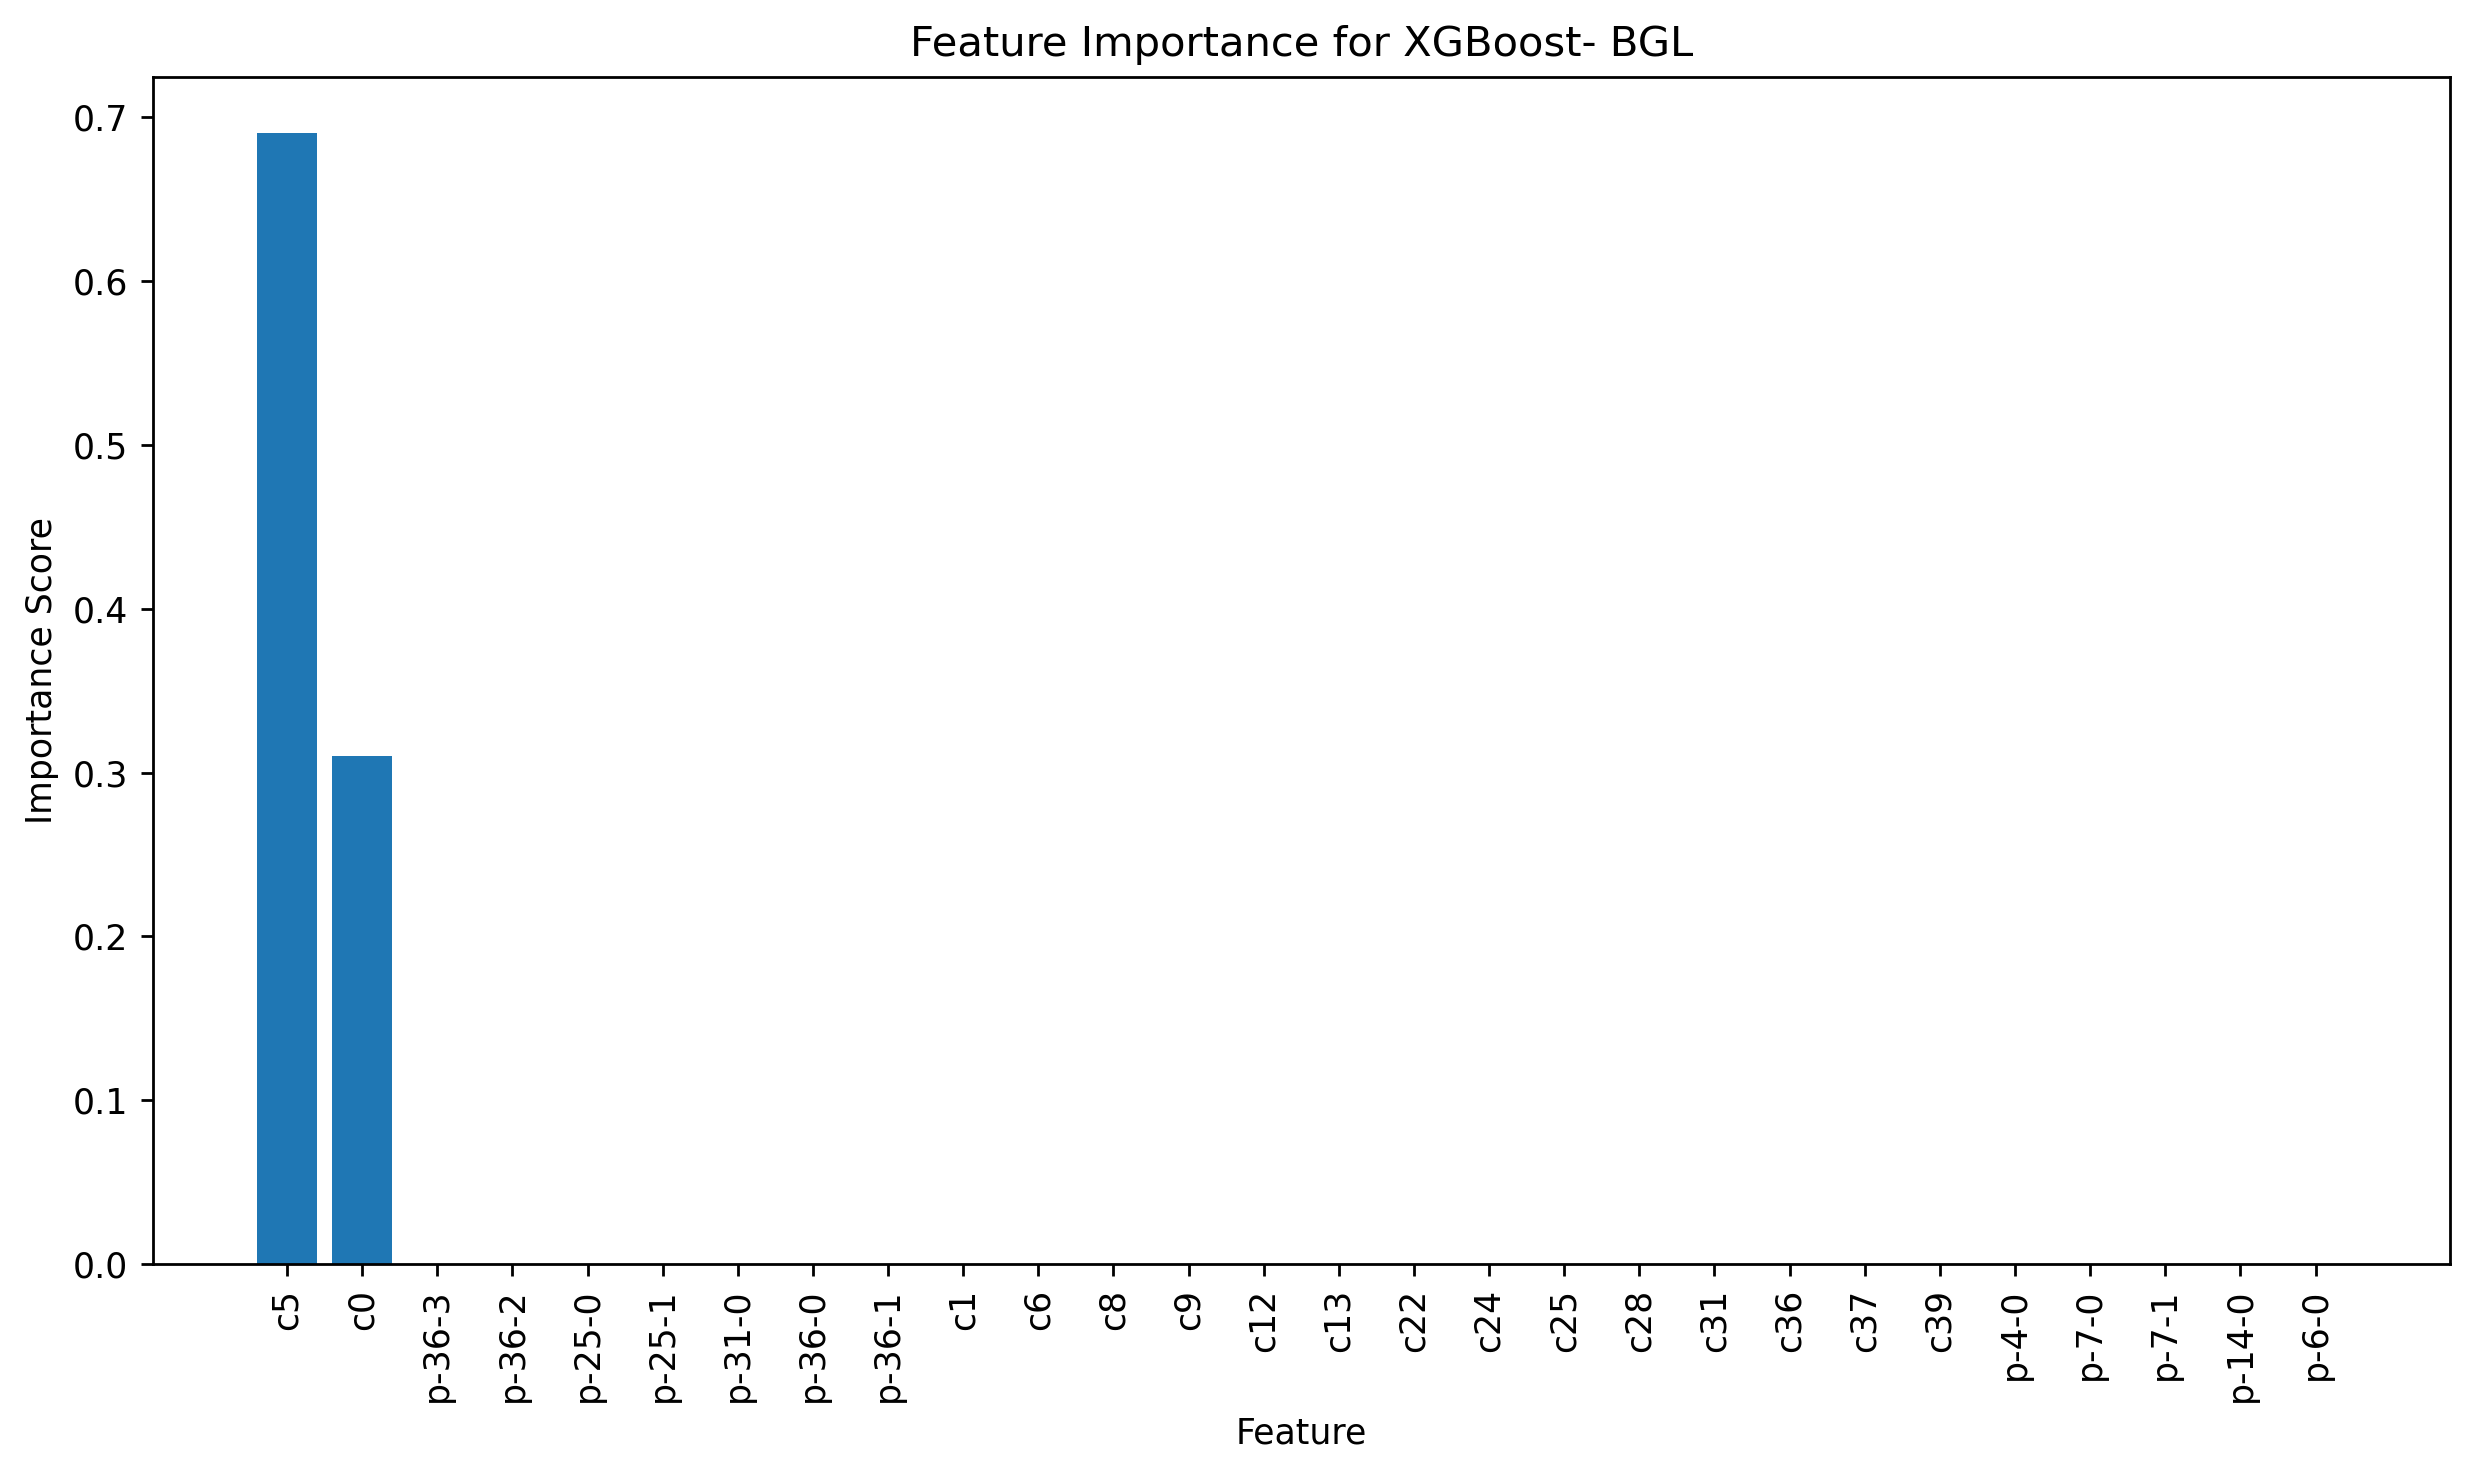

In [51]:
# Get the feature importance scores
importance_scores = bst.feature_importances_
feature_names = x_train_BGL.columns

# Sort the features based on their importance scores
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_scores = importance_scores[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot the feature importance using bar plot
plt.figure(figsize=(10, 6),dpi=250)
plt.bar(range(len(sorted_feature_names)), sorted_scores, align='center')
plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Feature Importance for XGBoost- BGL')
plt.tight_layout()
plt.show()


### Predictions on train data

Test Result:
Accuracy Score: 85.51%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999960     0.999553  0.999937      0.999757      0.999937
recall         0.999974     0.999330  0.999937      0.999652      0.999937
f1-score       0.999967     0.999442  0.999937      0.999704      0.999937
support    75521.000000  4478.000000  0.999937  79999.000000  79999.000000
_______________________________________________
Confusion Matrix: 
 [[62399     2]
 [11592  5999]]

_______________________________________________
Recall Score: 
 0.3410266613609232
_______________________________________________
Roc AUC Score: 
 0.6704973052962531


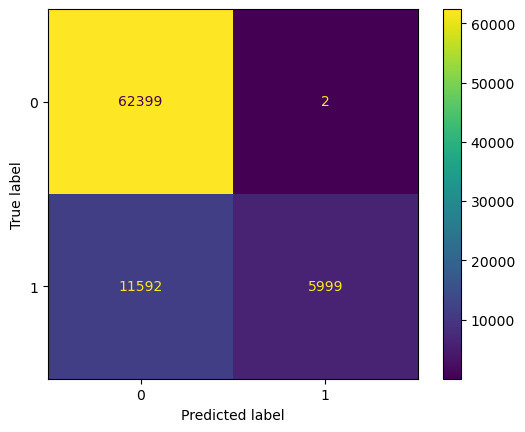

In [52]:
xgboost_report = pd.DataFrame(classification_report(y_train_BGL, preds_train, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_train_BGL, preds_train) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{lr_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_train_BGL, preds_train)}\n")
print("_______________________________________________")
print(f'Recall Score: \n {recall_score(y_train_BGL, preds_train)}')
print("_______________________________________________")
print(f'Roc AUC Score: \n {roc_auc_score(y_train_BGL, preds_train)}')

lr_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_train_BGL, preds_train)
plt.show()

### Predictions on test data

Test Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999960     0.999553  0.999937      0.999757      0.999937
recall         0.999974     0.999330  0.999937      0.999652      0.999937
f1-score       0.999967     0.999442  0.999937      0.999704      0.999937
support    75521.000000  4478.000000  0.999937  79999.000000  79999.000000
_______________________________________________
Confusion Matrix: 
 [[15601     0]
 [    0  4398]]

_______________________________________________
Recall Score: 
 1.0
_______________________________________________
Roc AUC Score: 
 1.0


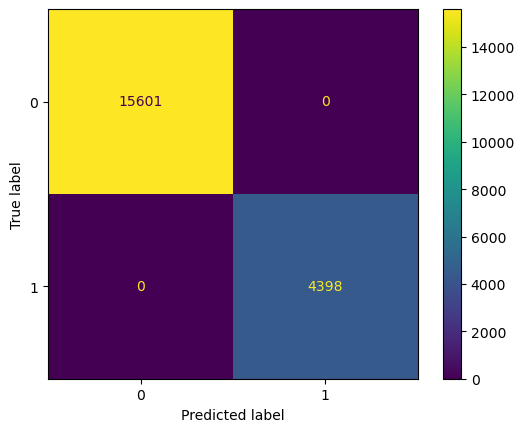

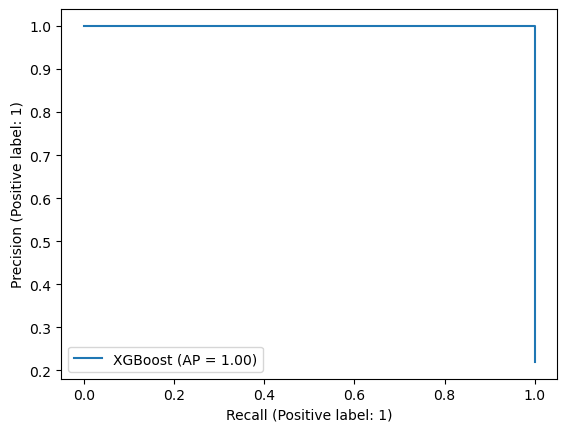

In [54]:
xgboost_report = pd.DataFrame(classification_report(y_test_BGL, preds_test, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test_BGL, preds_test) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{lr_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test_BGL, preds_test)}\n")
print("_______________________________________________")
print(f'Recall Score: \n {recall_score(y_test_BGL, preds_test)}')
print("_______________________________________________")
print(f'Roc AUC Score: \n {roc_auc_score(y_test_BGL, preds_test)}')

lr_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test_BGL, preds_test)
plt.show()

#pred_probs = lr.predict_prob(x_test)
#precision, recall, thresholds = precision_recall_curve(y_test, pred_probs)

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    bst, x_test_BGL, y_test_BGL, name="XGBoost"
)